(16430, 1)

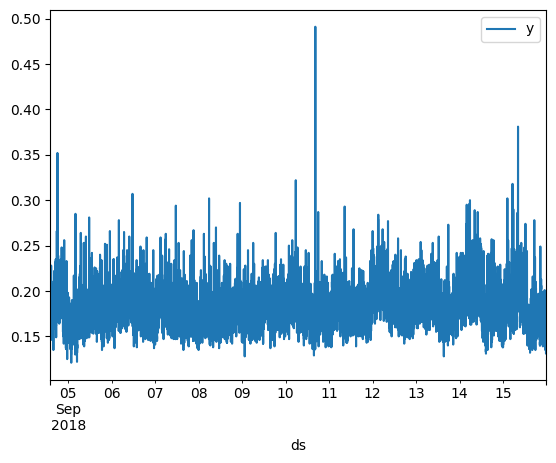

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('/home/lemateus/TCC/cintilacao/data/PRU2_2018-09-01_2018-09-15_9464c9cda8dce80d71af4c0f7524355bEDITADO.csv', na_values=[' ', ''])

data['time_utc'] = pd.to_datetime(data['time_utc'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[data['time_utc']>='2018-09-04 14:10:00']
# values = data[' svid'].value_counts()[:4].index.tolist()
# values = data[' svid'].value_counts()[:6]
# print(values)
# data = data[data[' svid'].isin(values)]
data = data[data[' svid'] == 131]
data = data[['time_utc', ' s4']]
data.columns = ['ds', 'y']
data['y'] = data['y'].astype(float)
# data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
# print(data.dtypes)
# data = data[:1000]
# print(data)
# data = data[:50]

# train = data.loc[data['ds']<'2018-09-14 23:59:00']
# test = data.loc[data['ds']>='2018-09-14 23:59:00']
data.plot(x='ds', y='y')
# plt.plot(data['ds'], data['y'])
data.to_csv('/home/lemateus/TCC/cintilacao/only_131.csv')
data.interpolate('linear')
# print(data[data['y'] == data['y'].max()])
timeseries = data[['y']].values.astype('float32')
timeseries.shape
# train

In [55]:
# train-test split for time series
train_size = 16430 - 1440
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
train.shape, test.shape

((14990, 1), (1440, 1))

In [56]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [57]:
lookback = 100
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([14890, 100, 1]) torch.Size([14890, 100, 1])
torch.Size([1340, 100, 1]) torch.Size([1340, 100, 1])


In [58]:
...
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        # x = x[:, -1, :]
        x = self.linear(x)
        return x

In [59]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0157, test RMSE 0.0162
Epoch 10: train RMSE 0.0154, test RMSE 0.0158
Epoch 20: train RMSE 0.0150, test RMSE 0.0160
Epoch 30: train RMSE 0.0147, test RMSE 0.0164
Epoch 40: train RMSE 0.0141, test RMSE 0.0168


torch.Size([14890, 100, 1])


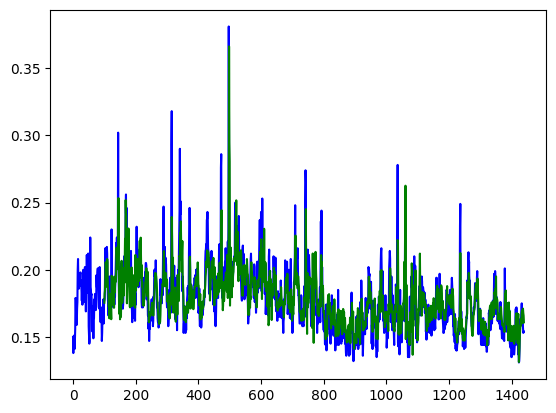

In [60]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    print(y_pred.shape)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
timeseries = timeseries[-1440:]
plt.plot(timeseries, c='b')
# plt.plot(train_plot, c='r')
test_plot = test_plot[-1440:]
plt.plot(test_plot, c='g')
plt.show()